## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
from torch.nn import functional as thf
import torchvision as tv

## Config

In [7]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_size = 28 * 28
latent_size = 20
hidden_size = 400
num_epochs = 15
batch_size = 128
learning_rate = 0.001


Using cuda


## MNIST Dataset

In [0]:
dataset = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=tv.transforms.ToTensor(),
    download=True)
data_loader = th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True)

test_dataset = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=False, transform=tv.transforms.ToTensor(),
    download=True)
test_loader = th.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True)

## Model

In [0]:
class VAE(nn.Module):
  def __init__(self, image_size, h_dim, z_dim):
    super(VAE, self).__init__()
    self.enc_h = nn.Linear(image_size, h_dim)
    self.enc_mu = nn.Linear(h_dim, z_dim)
    self.enc_logvar = nn.Linear(h_dim, z_dim)
    self.dec_h = nn.Linear(z_dim, h_dim)
    self.dec_img = nn.Linear(h_dim, image_size)
    
  def encode(self, x):
    h = thf.relu(self.enc_h(x))
    return self.enc_mu(h), self.enc_logvar(h)
  
  def sample_normal(self, mu, logvar):
    std = th.exp(logvar / 2)
    x = th.randn_like(std)
    return mu + x * std
  
  def decode(self, z):
    h = thf.relu(self.dec_h(z))
    return thf.sigmoid(self.dec_img(h))
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.sample_normal(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar
  
model = VAE(image_size, hidden_size, latent_size).to(device)

## Train

In [0]:
import collections
import copy

class ModelSnapshots(object):
  def __init__(self):
    self._snapshots = collections.OrderedDict()

  def snapshot(self, model, key):
    self._snapshots[key] = copy.deepcopy(model)
    
  def get(self, key):
    return self._snapshots[key]
  
model_snapshots = ModelSnapshots()

In [8]:
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

num_steps = len(data_loader)
for epoch in range(num_epochs):
  for step, (x, _) in enumerate(data_loader):
    x = x.to(device).view(-1, image_size)
    x_reconst, mu, logvar = model(x)
    
    # Compute reconstruction loss and KL-divergence.
    # See Appendix B in VAE paper.
    reconst_loss = thf.binary_cross_entropy(x_reconst, x, size_average=False)
    kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Backprop.
    loss = reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Reconst loss: {reconst_loss.item():.4f}, '
        f'KL Div: {kl_div.item():.4f}')
  model_snapshots.snapshot(model, epoch)

Epoch [1/15], Reconst loss: 7091.0640, KL Div: 2376.2224
Epoch [2/15], Reconst loss: 7290.8452, KL Div: 2455.8381
Epoch [3/15], Reconst loss: 7082.7412, KL Div: 2400.4294
Epoch [4/15], Reconst loss: 7300.9834, KL Div: 2416.8799
Epoch [5/15], Reconst loss: 7020.7241, KL Div: 2338.6799
Epoch [6/15], Reconst loss: 7099.5737, KL Div: 2346.1135
Epoch [7/15], Reconst loss: 6823.0981, KL Div: 2320.8867
Epoch [8/15], Reconst loss: 6957.7798, KL Div: 2453.1736
Epoch [9/15], Reconst loss: 7205.5962, KL Div: 2376.7959
Epoch [10/15], Reconst loss: 7119.4058, KL Div: 2382.2974
Epoch [11/15], Reconst loss: 7140.2930, KL Div: 2377.0632
Epoch [12/15], Reconst loss: 7102.8794, KL Div: 2403.6443
Epoch [13/15], Reconst loss: 7134.6177, KL Div: 2349.1958
Epoch [14/15], Reconst loss: 7222.4810, KL Div: 2441.1094
Epoch [15/15], Reconst loss: 7288.2109, KL Div: 2455.8936


## Test

In [0]:
import math
      
def sample_images(model, num_samples=1):
  with th.no_grad():
    z = th.randn(num_samples, latent_size).to(device)
    images = model.decode(z).view(-1, 1, 28, 28)
  return images.cpu().numpy()

def visualize_images(images, title=None, rows=None, cols=10):
  rows = rows or int(math.ceil(images.shape[0] / cols))
  fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
  fig.suptitle(title)
  for r in range(rows):
    for c in range(cols):
      image = images[r * cols + c, :, :, :].squeeze()
      subplot = axes[r, c] if rows > 1 else axes[c]
      subplot.imshow(image, cmap='gray')
      subplot.axis('off')

### Reconstructing test set

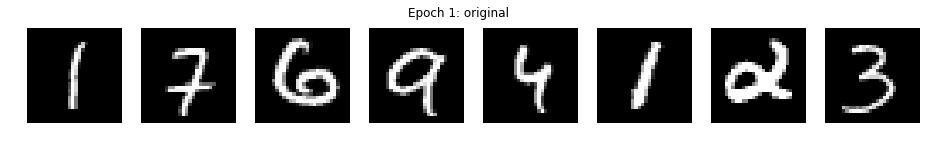

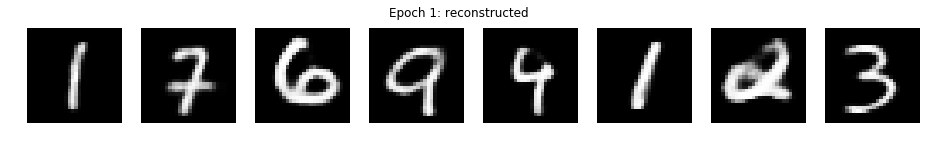

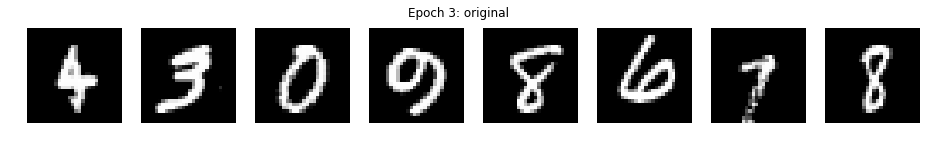

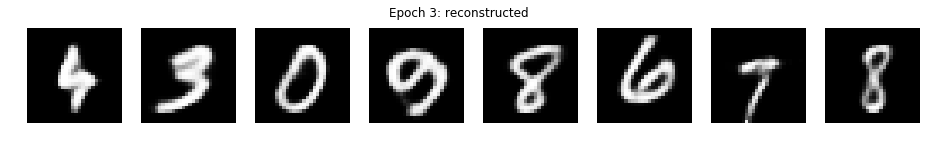

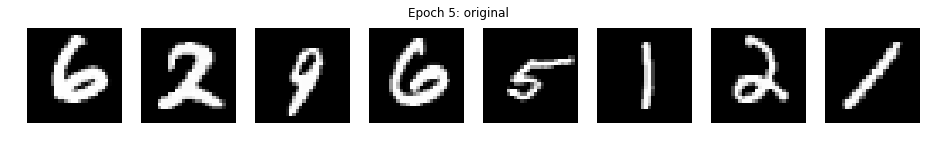

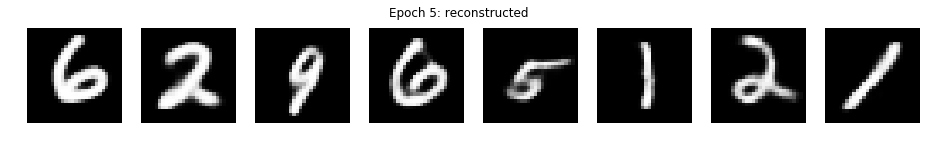

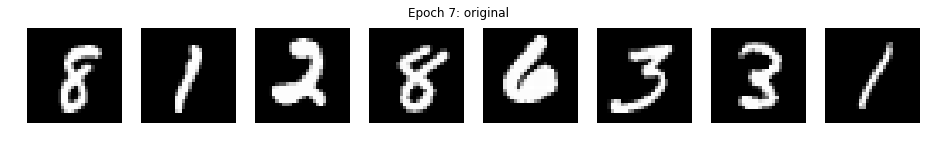

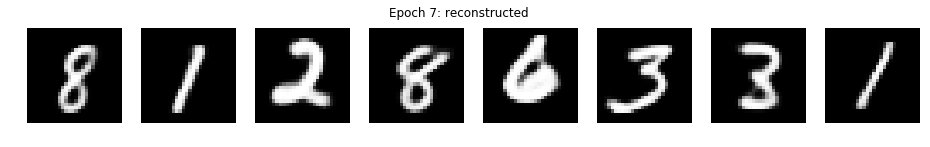

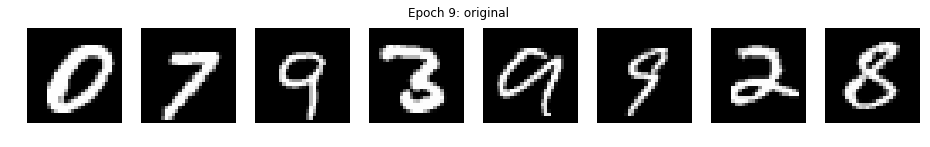

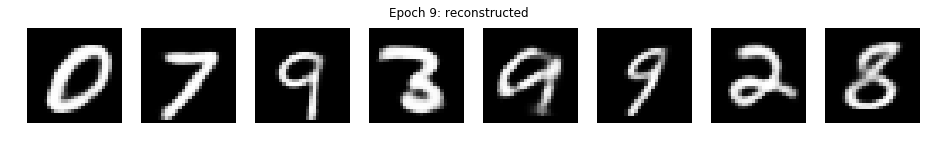

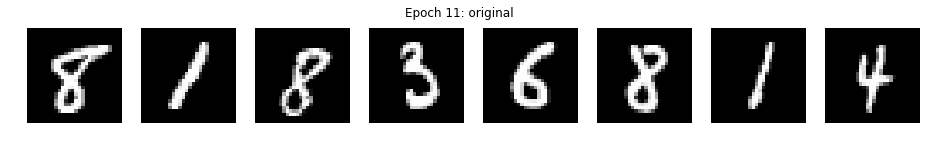

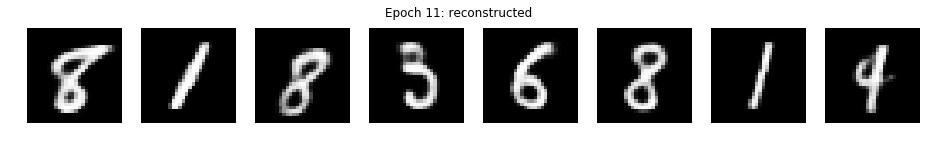

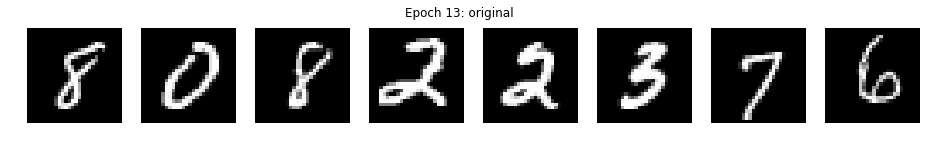

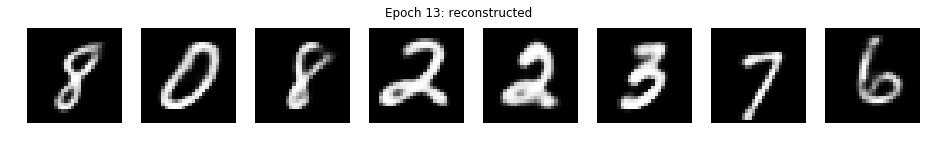

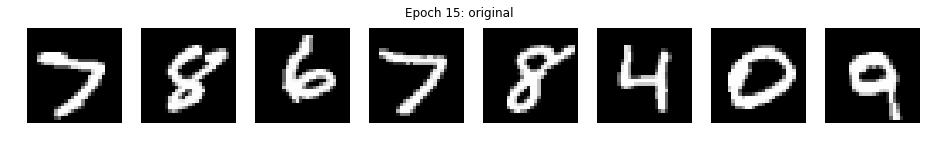

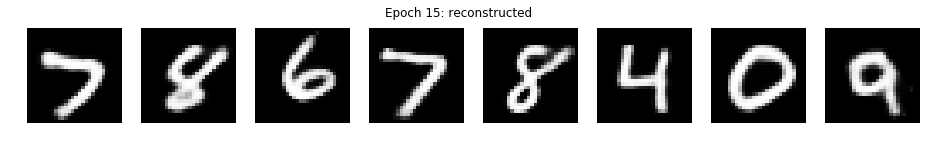

In [10]:
for epoch, (test_images, _) in zip(range(0, num_epochs, 2), test_loader):
  model_t = model_snapshots.get(epoch)
  test_batch = test_images.to(device).view(-1, image_size)
  with th.no_grad():
    reconst_images, _, _ = model_t(test_batch)
  reconst_images = reconst_images.view(-1, 1, 28, 28)
  visualize_images(test_images, title=f'Epoch {epoch+1}: original',
                   rows=1, cols=8)
  visualize_images(reconst_images, title=f'Epoch {epoch+1}: reconstructed',
                   rows=1, cols=8)

### Sampling z ~ N(0, 1)

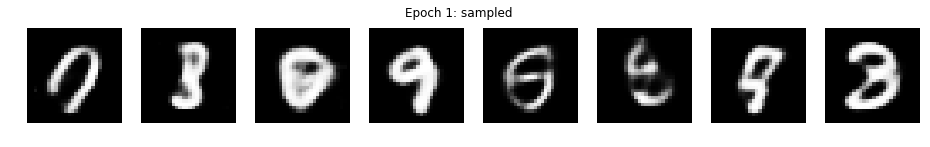

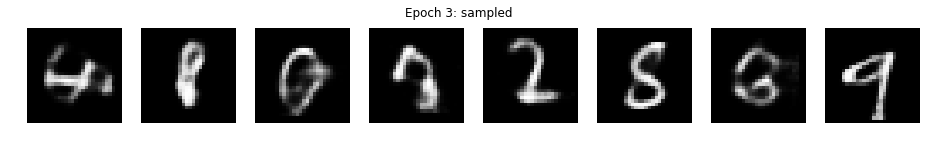

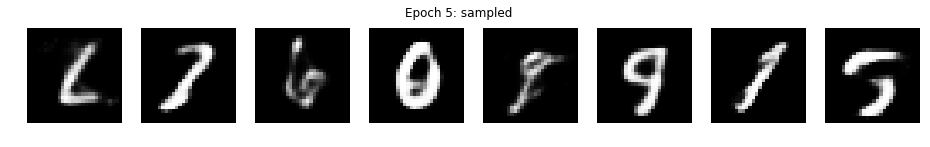

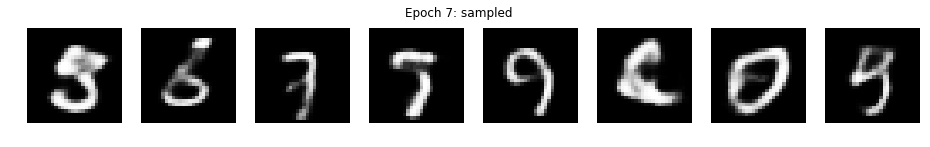

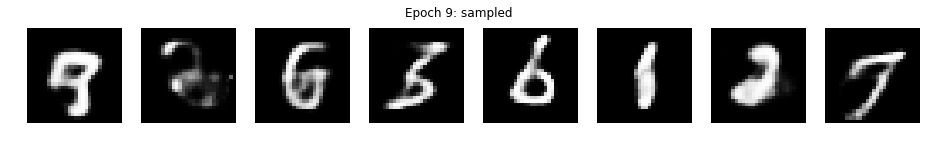

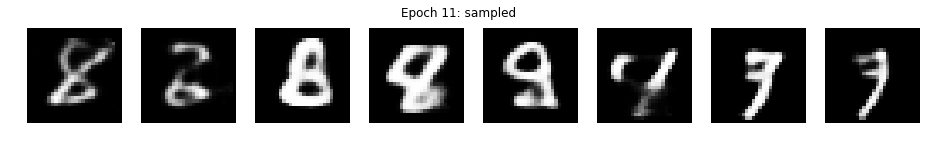

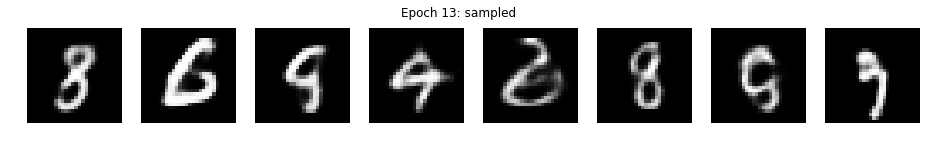

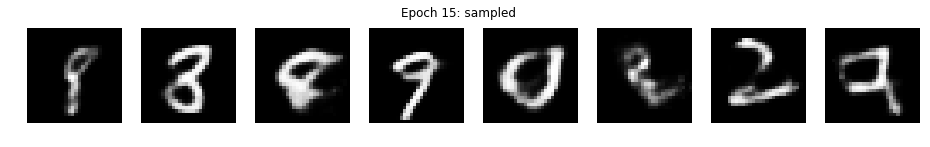

In [11]:
for epoch in range(0, num_epochs, 2):
  model_t = model_snapshots.get(epoch)
  images = sample_images(model_t, num_samples=batch_size)
  visualize_images(images, title=f'Epoch {epoch+1}: sampled', rows=1, cols=8)

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/vae.ckpt')